In [7]:
import pickle 
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.optimize import minimize
from IPython.display import display, Latex


In [8]:
d2metals = {
    '3': ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni'],
    '4': ['Nb', 'Mo', ],
    '5': ['W', ]
}

# for plotting
ele2col = {
    "Ti": "#808080",
    "V": "#ffcccb",
    "Cr": "k",
    "Mn": "#9b870c",
    "Fe": "r",
    "Co": "b",
    "Cu": "#FFFF00",
    "Nb": "cyan",
    "Mo": "#FFA500",
    "Sn": "k",
    "W": "fuchsia",
    "Ir": "b",
    "Ni": "#66FF00",
}

In [9]:
def plot_parabola(parabola):
    x = np.linspace(0, 4, 10)
    y = parabola[0]*x**2+parabola[1]*x
    plt.plot(x, y)
    
def formation_energy_mixing(ele1, ele2, concentrations, plotting=False):
    ox_quadratic_1 = mp_quadratic_equations_ox[ele1]
    ox_quadratic_2 = mp_quadratic_equations_ox[ele2]
    red_quadratic_1 = mp_quadratic_equations_red[ele2]
    red_quadratic_2 = mp_quadratic_equations_red[ele1]

    predicted_forms_1 = []
    predicted_forms_2 = []
    predicted_ox_change_1 = []
    predicted_ox_change_2 = []
    for conc in concentrations:
        
        o_1a, o_2a, o_3a = ox_quadratic_1
        r_1a, r_2a, r_3a = red_quadratic_1

        o_1b, o_2b, o_3b = ox_quadratic_2
        r_1b, r_2b, r_3b = red_quadratic_2
        if plotting:
            #print('checking {}'.format(conc))
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a, True), bounds=[(0, 10)])
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b, True), bounds=[(0, 10)])
            
        else:
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a),  bounds=[(0, 10)])
            # Note, the definition of concentration is different  between 1/2,
            # since it relates to the concentration of the element that is 
            # oxidisint or reducing.
            #handle this when plotting by flipping the x-axis horizontally
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b),  bounds=[(0, 10)])
        
        x_space = np.linspace(0, 3, 50)
        predicted_ox_change_1.append(result_1.x[0])
        # this can give problems depending on scipy version, might have to use result_1.fun
        predicted_forms_1.append(result_1.fun)
        predicted_ox_change_2.append(result_2.x[0])
        predicted_forms_2.append(result_2.fun)#result_2.fun[0] + diff*(1-conc))
        
#         mixed_1 = o_1a*(x_space**2)*(1-conc)**2+o_2a*x_space*(1-conc)+r_1a*(x_space**2)*conc**2+r_2a*x_space*conc
#         ox1 = o_1a*x_space**2+o_2a*x_space
#         red1 = r_1a*x_space**2+r_2a*x_space
        
#         mixed_2 = o_1b*(x_space**2)*(conc)**2+o_2b*x_space*(conc)+(r_1b*((1-conc)*x_space)**2+r_2b*(1-conc)*x_space)
#         ox2 = o_1b*x_space**2+o_2b*x_space
#         red2 = r_1b*x_space**2+r_2b*x_space
#         if conc==0 or conc==1:
#             continue

    xs_1 = []
    xs_2 = []
    for conc in concentrations:
        # need to shift the energies so that either end is set to 0
        # so shift every point proportionally
        xs_1.append(predicted_forms_1[0]*(1-conc)+predicted_forms_1[-1]*(conc))
        xs_2.append(predicted_forms_2[0]*(1-conc)+predicted_forms_2[-1]*(conc))
        
    return np.array(predicted_forms_1)-xs_1, np.array(predicted_forms_2)-xs_2, predicted_ox_change_1, predicted_ox_change_2

def oxidation_reduction_equation(x, ox_conc, o1, o2, r1, r2, plot=False):
    """
    Defines the equation to optimize oxidation state when mixed
    Args:
    x: The amount of oxidation state change
    ox_conc: The concentration of the oxidising element between 0 and 1
    o1, o2, o3: Define the quadratic equation for the oxidising element
    r1, r2, r3: Define the quadratic equation for the reducing element
    """
    return (o1*x**2*(1-ox_conc)**2+o2*x*(1-ox_conc))+(r1*(ox_conc*x)**2+r2*(ox_conc*x))


def find_nearest(array, value):
    """
    Helper function to find the closest conc
    """
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx


In [10]:
mp_quadratic_equations_ox = pickle.load(open('make_quadratics/mp_quadratic_equations_ox.p', 'rb'))
mp_quadratic_equations_red = pickle.load(open('make_quadratics/mp_quadratic_equations_red.p', 'rb'))

binary_pairing_data = pickle.load(open('data_gather/binary_pairing_data.p', 'rb'))

# iterate over these eqs, removing the oxidation number label to get all the elements 
set_of_elements = set([x[:-1] for x in mp_quadratic_equations_ox])
# these give issues in that they cause a bug where the code finds or Ir Yb entries 
# when it shouldn't. I gets mistakenly matched with Ir data, and Y with Yb data.
set_of_elements.remove("I")
set_of_elements.remove("Y")


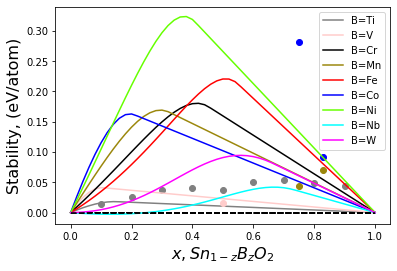

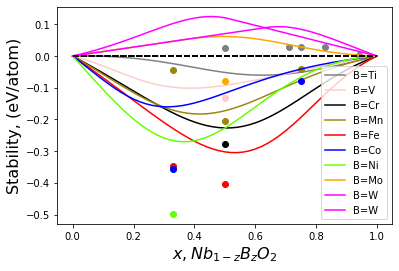

In [11]:
oxidation_state = 4
for housing_element in ['Sn', 'Nb']:
    house_ele_ox = housing_element+str(oxidation_state)
    #print(house_ele_ox)
    if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    zs = np.linspace(0, 1.00, 51)

    for ele in d2metals['3']+d2metals['4']+d2metals['5']:
        #print(ele)
        dope_ele_ox = ele+str(oxidation_state)
        if ele==housing_element:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(zs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        if can_oxidise:
            plt.plot(zs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        
        if ele<housing_element:
            info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(4)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
        else:
            info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(4)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])

        
    plt.legend()
    plt.xlabel("$x, {}_{{1-z}}B_{{z}}O_{{2}}$".format(housing_element, ), fontsize=16)
    plt.ylabel("Stability, (eV/atom)", fontsize=16)
    #plt.ylim(-0.1, 0.1)
    plt.savefig("{}_higherdmixing.pdf".format(housing_element))
    plt.show()
        
        

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 777
MAE for unfiltered: 0.236
total matches with good geom: 232
MAE for filtered: 0.127


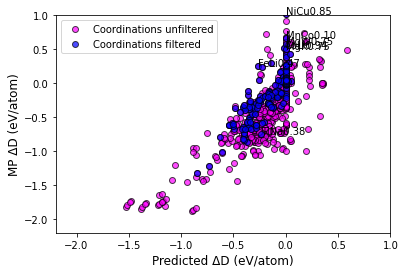

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 1369
MAE for unfiltered: 0.248
total matches with good geom: 176
MAE for filtered: 0.117


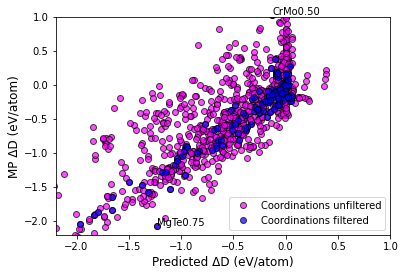

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 932
MAE for unfiltered: 0.120
total matches with good geom: 298
MAE for filtered: 0.096


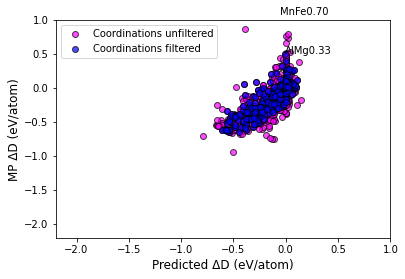

In [12]:
ox2oxide_type = {
    "2": "$A_{1-z}B_{z}O$",
    "3": "$A_{1-z}B_{z}O_{1.5}$",
    "4": "$A_{1-z}B_{z}O_{2}$"
}
maes = []
num_oxides = []

good_maes = []
num_good_oxides = []

for oxidation_state in [2, 3, 4]:
    print("Checking oxides of type as below")
    display(Latex(ox2oxide_type[str(oxidation_state)]))
    data_dict = defaultdict()
    seen_combinations = []

    for housing_element in set_of_elements:
        house_ele_ox = housing_element+str(oxidation_state)
        if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
            print("Missing eq for {}".format(housing_element))
            continue

        pairings = []
        ground_states =  []
        zs = np.linspace(0, 1.00, 51)

        for ele in set_of_elements:
            dope_ele_ox = ele+str(oxidation_state)
            if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                continue
            else:
                seen_combinations.append(ele+housing_element)
            if ele<housing_element:
                info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
            else:
                info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
            if len(info_dict)==0:
                continue

            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )
            for ele_conc in info_dict:
                conc = float(ele_conc.split("_")[1])
                #closest_idx = find_nearest(zs, conc)
                if ele+"_{:.2f}".format(conc)==ele_conc:# in info_dict.keys():
                    # the 'element' variable is the one with that conc
                    # the ele conc is the one we get a ΔD value for at 
                    # given conc, and this has to match the way
                    # the weighted average was calculated
                    # this key will be accessed later
                    inner_key = ele+housing_element+"{:.2f}".format(conc)
                    closest_idx = find_nearest(zs, conc)

                elif housing_element+"_{:.2f}".format(conc)==ele_conc:
                    # the 'housing_element' is the one with that conc
                    inner_key = housing_element+ele+"{:.2f}".format(conc)
                    # since the ΔD is calculated for ele conc, need to switch 
                    # to the other side of the diagram
                    closest_idx = find_nearest(zs, 1-conc)
                    
                if pred_2[closest_idx]<pred_1[closest_idx]:
                    ox_change = ox_2[closest_idx]
                else:
                    ox_change = ox_1[closest_idx]

                data_dict[inner_key] = {
                    "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                    "true ΔD": info_dict[ele_conc]['MP ΔD'],
                    "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[ele_conc]['MP weighted average'],
                    "true formation energy": info_dict[ele_conc]['MP weighted average']+info_dict[ele_conc]['MP ΔD'],
                    "weighted average of refs": info_dict[ele_conc]['MP weighted average'],
                    "coordination_match": info_dict[ele_conc]['Coordination match'],
                    "x_tot": ox_change,
                    "mp_id": info_dict[ele_conc]['MP_id'],
                    "mp_name": info_dict[ele_conc]['MP_name'],
                    "motifs": info_dict[ele_conc]['motifs'],
                }
    xs = []
    ys = []
    for key, val in data_dict.items():
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])

    print("total matches: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='fuchsia', alpha=0.7, label='Coordinations unfiltered', markeredgecolor='k')
    print("MAE for unfiltered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    maes.append(np.mean(abs(np.array(xs)-np.array(ys))))
    num_oxides.append(len(xs))
    #plt.show()
    xs = []
    ys = []
    for key, val in data_dict.items():
        if not val['coordination_match']:
            # bad geometry
            continue
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])
        if abs(xs[-1]-ys[-1])>0.5:
            plt.text(xs[-1], ys[-1], "{}".format(key))

    print("total matches with good geom: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='b', alpha=0.7, label='Coordinations filtered', markeredgecolor='k')
    print("MAE for filtered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.legend()
    plt.xlim(-2.2, 1.)
    plt.ylim(-2.2, 1.)
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    #plt.savefig("parities_ox_state_{}.pdf".format(oxidation_state))
    plt.show()
    good_maes.append(np.mean(abs(np.array(xs)-np.array(ys))))
    num_good_oxides.append(len(xs))


In [13]:
total_oxides = sum(num_oxides)
unfiltered_avg = 0
for num_ox, mae in zip(num_oxides, maes):
    unfiltered_avg+=num_ox*mae*(1.0/total_oxides)
print("Total MAE for unfiltered: {:.3f} eV/atom".format(unfiltered_avg))
total_oxides = sum(num_good_oxides)
filtered_avg = 0
for num_ox, mae in zip(num_good_oxides, good_maes):
    filtered_avg+=num_ox*mae*(1.0/total_oxides)
print("Total MAE for filtered: {:.3f} eV/atom".format(filtered_avg))


Total MAE for unfiltered: 0.206 eV/atom
Total MAE for filtered: 0.112 eV/atom


### Printing for spreadsheet

In [14]:
ox2oxide_type = {
    "2": "$A_{1-z}B_{z}O$",
    "3": "$A_{1-z}B_{z}O_{1.5}$",
    "4": "$A_{1-z}B_{z}O_{2}$"
}
for oxidation_state in [2, 3, 4]:
    print("Checking oxides of type as below")
    display(Latex(ox2oxide_type[str(oxidation_state)]))
    data_dict = defaultdict()
    seen_combinations = []

    for housing_element in set_of_elements:
        house_ele_ox = housing_element+str(oxidation_state)
        if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
            print("Missing eq for {}".format(housing_element))
            continue

        pairings = []
        ground_states =  []
        zs = np.linspace(0, 1.00, 51)

        for ele in set_of_elements:
            dope_ele_ox = ele+str(oxidation_state)
            if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                continue
            else:
                seen_combinations.append(ele+housing_element)
            if ele<housing_element:
                info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
            else:
                info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
            if len(info_dict)==0:
                continue

            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )
            for ele_conc in info_dict:
                conc = float(ele_conc.split("_")[1])
                #closest_idx = find_nearest(zs, conc)
                if ele+"_{:.2f}".format(conc)==ele_conc:# in info_dict.keys():
                    # the 'element' variable is the one with that conc
                    # the ele conc is the one we get a ΔD value for at 
                    # given conc, and this has to match the way
                    # the weighted average was calculated
                    # this key will be accessed later
                    inner_key = ele+housing_element+"{:.2f}".format(conc)
                    closest_idx = find_nearest(zs, conc)

                elif housing_element+"_{:.2f}".format(conc)==ele_conc:
                    # the 'housing_element' is the one with that conc
                    inner_key = housing_element+ele+"{:.2f}".format(conc)
                    # since the ΔD is calculated for ele conc, need to switch 
                    # to the other side of the diagram
                    closest_idx = find_nearest(zs, 1-conc)
                    
                if pred_2[closest_idx]<pred_1[closest_idx]:
                    ox_change = ox_2[closest_idx]
                else:
                    ox_change = ox_1[closest_idx]

                data_dict[inner_key] = {
                    "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                    "true ΔD": info_dict[ele_conc]['MP ΔD'],
                    "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[ele_conc]['MP weighted average'],
                    "true formation energy": info_dict[ele_conc]['MP weighted average']+info_dict[ele_conc]['MP ΔD'],
                    "weighted average of refs": info_dict[ele_conc]['MP weighted average'],
                    "coordination_match": info_dict[ele_conc]['Coordination match'],
                    "x_tot": ox_change,
                    "mp_id": info_dict[ele_conc]['MP_id'],
                    "mp_name": info_dict[ele_conc]['MP_name'],
                    "motifs": info_dict[ele_conc]['motifs'],
                }
                print(data_dict[inner_key]['mp_name'], end=", ")
                print(data_dict[inner_key]['mp_id'], end=", ")
                print("{:.4f}".format(data_dict[inner_key]['true formation energy']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['predicted formation energy']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['true ΔD']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['predicted ΔD']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['weighted average of refs']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['x_tot']), end=", ")
                print(data_dict[inner_key]['coordination_match'], end=", ")
                motifs2print = ""
                for motif in data_dict[inner_key]['motifs']:
                    motifs2print+=motif+"/"
                motifs2print = motifs2print[:-1]
                print(motifs2print)




Checking oxides of type as below


<IPython.core.display.Latex object>

HgPtO2, mp-754538, -0.6805, -0.6102, -0.0703, 0.0000, -0.6102, 0.0000, False, octahedral/unrecognized
TlPt3O4, mp-1208033, -0.8821, -0.6215, -0.3355, -0.0749, -0.5465, 1.2476, False, unrecognized/bcc/cp
CaPt3O4, mp-755647, -1.4037, -1.2645, -0.1392, 0.0000, -1.2645, 0.0000, False, bcc/unrecognized
AgPtO2, mp-997006, -0.6742, -0.5138, -0.1604, 0.0000, -0.5138, 0.0000, False, octahedral/unrecognized
CrPtO2, mp-755584, -1.6535, -1.2360, -0.3788, 0.0388, -1.2747, 1.2695, False, octahedral/unrecognized
ZnPt3O4, mp-1207390, -0.7643, -0.8850, 0.1207, 0.0000, -0.8850, 0.0000, False, bcc/unrecognized
CoPtO2, mp-19210, -1.0295, -0.9334, -0.0961, 0.0000, -0.9334, 0.0000, False, octahedral/unrecognized
Cu4PtO5, mp-753552, -0.9006, -0.8701, -0.0305, 0.0000, -0.8701, 0.0000, False, unrecognized
CuPtO2, mp-997098, -0.8314, -0.7626, -0.0688, 0.0000, -0.7626, 0.0000, False, unrecognized
Na2PtO3, mp-560860, -1.5064, -1.2671, -0.3634, -0.1241, -1.1430, 2.9510, True, octahedral
NaPt3O4, mp-20285, -1.0752,

CaAgO2, mp-997004, -1.9061, -1.8759, -0.0302, 0.0000, -1.8759, 0.0000, False, octahedral/unrecognized
CaSnO2, mvc-4868, -2.3324, -2.4725, 0.1401, 0.0000, -2.4725, 0.0000, False, square pyramidal/unrecognized
CaCrO2, mp-1214059, -2.6061, -2.6369, 0.0308, 0.0000, -2.6369, 0.0000, False, octahedral/unrecognized
CaZnO2, mp-1227007, -2.4117, -2.5489, 0.1372, 0.0000, -2.5489, 0.0000, False, tetrahedral
CaCoO2, mvc-2940, -2.0838, -2.2955, 0.2117, 0.0000, -2.2955, 0.0000, False, unrecognized
Ca2CoO3, mp-1182074, -2.4057, -2.6329, 0.2273, 0.0000, -2.6329, 0.0000, False, octahedral/square pyramidal
CaTiO2, mp-1244561, -2.9511, -3.1074, 0.1564, 0.0000, -3.1074, 0.0000, False, unrecognized
CaNbO2, mp-1213992, -2.3639, -2.7963, 0.4324, 0.0000, -2.7963, 0.0000, False, octahedral/unrecognized
Ca2CuO3, mp-5869, -2.5291, -2.5191, -0.0101, 0.0000, -2.5191, 0.0000, False, unrecognized
CaCuO2, mp-4826, -2.1274, -2.1248, -0.0026, 0.0000, -2.1248, 0.0000, False, bcc/unrecognized
CaCu3O4, mp-1147653, -1.5605

Li3AsO4, mp-9197, -2.2695, -1.8079, -0.8137, -0.3521, -1.4558, 1.3925, False, tetrahedral
CsTmO2, mp-753799, -3.0011, -2.5661, -1.6489, -1.2139, -1.3522, 1.7964, False, octahedral/unrecognized
LaTmO2, mp-753898, -3.2799, -2.2810, -0.9963, 0.0026, -2.2836, 1.4129, False, octahedral
RbTmO2, mp-7478, -3.0882, -2.5252, -1.7348, -1.1718, -1.3534, 1.7879, False, octahedral/unrecognized
NaTmO2, mp-754825, -3.2183, -2.7682, -1.8250, -1.3748, -1.3934, 2.0000, False, octahedral
KTmO2, mp-753774, -3.1646, -2.5939, -1.7799, -1.2092, -1.3847, 1.7853, False, octahedral/unrecognized
LiTmO2, mp-754237, -3.3499, -3.0764, -1.7879, -1.5143, -1.5620, 2.0000, False, octahedral/unrecognized
CsScO2, mp-754826, -2.9788, -2.5583, -0.6888, -0.2684, -2.2900, 1.4663, False, tetrahedral/unrecognized
Cs2ZrO3, mp-8759, -2.7325, -2.0588, -0.9866, -0.3130, -1.7459, 2.4545, False, unrecognized
CsAuO2, mp-997024, -1.1371, -0.8488, -0.3908, -0.1025, -0.7463, 1.1872, False, unrecognized
Cs2CeO3, mp-768223, -2.6735, -2.181

KAuO2, mp-997002, -1.1482, -0.8839, -0.3694, -0.1051, -0.7788, 1.1722, False, unrecognized
BiAuO2, mp-997082, -1.1178, -0.8229, -0.6000, -0.3051, -0.5178, 1.8997, False, unrecognized
BaAuO2, mp-997009, -1.7825, -1.4874, -0.2951, 0.0000, -1.4874, 0.0000, False, octahedral/unrecognized
FeAuO2, mp-996994, -1.1545, -0.8595, -0.3380, -0.0430, -0.8165, 1.6622, False, octahedral/unrecognized
GaAuO2, mp-11021, -1.5053, -1.1355, -0.7374, -0.3675, -0.7680, 1.9139, False, octahedral/unrecognized
CdAuO2, mp-997036, -0.9015, -0.7621, -0.1394, 0.0000, -0.7621, 0.0000, False, unrecognized
NiAuO2, mp-997095, -0.8268, -0.6847, -0.1421, 0.0000, -0.6847, 0.0000, False, octahedral/unrecognized
LiAuO2, mp-996959, -1.2361, -1.2588, -0.2799, -0.3026, -0.9562, 2.0000, False, unrecognized
MnAuO2, mp-997183, -1.3742, -1.0591, -0.3089, 0.0062, -1.0653, 0.8573, False, unrecognized
CeGeO2, mp-1213932, -2.1828, -1.9028, -0.0469, 0.2331, -2.1360, 1.3229, False, octahedral/unrecognized
CeAlO2, mp-1226604, -2.8775, -2

LaCuO2, mp-20072, -2.6878, -2.0725, -0.6152, 0.0000, -2.0725, 0.0000, False, unrecognized
NaLaO2, mp-755586, -3.0422, -2.6587, -0.7291, -0.3457, -2.3131, 2.0000, False, octahedral/unrecognized
LaWO2, mp-1211437, -1.7124, -2.1342, 0.6170, 0.1952, -2.3295, 0.9131, False, octahedral/unrecognized
KLaO2, mp-7958, -3.0088, -2.5484, -0.7044, -0.2440, -2.3044, 1.4212, False, octahedral
LaNiO2, mp-20392, -2.3387, -2.2103, -0.1285, 0.0000, -2.2103, 0.0000, False, bcc/unrecognized
LiLaO2, mp-756544, -3.1800, -2.9669, -0.6983, -0.4852, -2.4817, 2.0000, False, unrecognized
ZnSnO2, mvc-14586, -1.6132, -1.7137, 0.1004, 0.0000, -1.7137, 0.0000, False, tetrahedral/unrecognized
Rb2SnO3, mp-753798, -1.9251, -1.5060, -0.4840, -0.0650, -1.4411, 1.9711, False, unrecognized
Na2SnO3, mp-761184, -2.0781, -1.6609, -0.5838, -0.1666, -1.4943, 2.9483, False, octahedral/unrecognized
MgSnO2, mvc-13666, -2.1694, -2.3455, 0.1761, 0.0000, -2.3455, 0.0000, False, unrecognized
KSnO2, mp-752538, -1.9011, -1.5292, -0.3797,

RbHoO2, mp-6978, -3.0551, -2.5430, -0.8219, -0.3098, -2.2332, 1.5077, False, octahedral/unrecognized
RbCoO2, mp-1147736, -1.3115, -1.3169, 0.0017, -0.0038, -1.3131, 0.4165, False, tetrahedral/unrecognized
Rb2CoO3, mp-1278131, -1.4628, -1.3220, -0.1398, 0.0011, -1.3231, 0.4088, False, unrecognized
RbDyO2, mp-7476, -3.0412, -2.4842, -1.7017, -1.1446, -1.3395, 1.7842, False, octahedral/unrecognized
Rb2TiO3, mp-5403, -2.7502, -1.9441, -0.8859, -0.0797, -1.8643, 2.0186, False, tetrahedral/unrecognized
RbCuO2, mp-7467, -1.3567, -1.1509, -0.2143, -0.0085, -1.1424, 0.4310, False, unrecognized
Rb2PbO3, mp-21461, -1.5548, -1.4004, -0.1701, -0.0157, -1.3846, 0.5588, False, unrecognized
RbErO2, mp-7477, -3.0686, -2.5536, -0.8338, -0.3188, -2.2348, 1.5148, False, octahedral/unrecognized
Rb4WO5, mp-1209481, -2.0322, -1.3896, -0.6667, -0.0241, -1.3655, 3.5825, False, trigonal bipyramidal/unrecognized
RbBiO2, mp-29521, -1.6939, -1.3580, -0.5807, -0.2448, -1.1132, 1.4472, False, unrecognized
RbSbO2, mp

CuBiO2, mp-997054, -1.2601, -0.9126, -0.3475, 0.0000, -0.9126, 0.0000, False, unrecognized
Ba2CuO3, mp-8790, -2.2849, -2.1957, -0.0892, 0.0000, -2.1957, 0.0000, False, unrecognized
BaCu3O4, mp-3988, -1.4556, -1.4120, -0.0436, 0.0000, -1.4120, 0.0000, False, unrecognized
BaCuO2, mp-997034, -1.9909, -1.8822, -0.1088, 0.0000, -1.8822, 0.0000, False, unrecognized
FeCuO2, mp-510281, -1.3203, -1.2113, -0.1090, 0.0000, -1.2113, 0.0000, False, octahedral/unrecognized
EuCuO2, mp-13696, -2.2830, -2.0309, -0.2521, 0.0000, -2.0309, 0.0000, False, octahedral/unrecognized
GaCuO2, mp-11019, -1.6740, -1.1966, -0.5112, -0.0338, -1.1628, 1.4673, False, octahedral/unrecognized
CdCu2O3, mp-754978, -1.0457, -1.0852, 0.0395, 0.0000, -1.0852, 0.0000, False, unrecognized
CuNiO2, mp-1178372, -1.0128, -1.0795, 0.0667, 0.0000, -1.0795, 0.0000, False, octahedral/unrecognized
CuNi4O5, mp-1225756, -1.0906, -1.1621, 0.0716, 0.0000, -1.1621, 0.0000, True, octahedral
CuNi3O4, mp-761415, -1.0839, -1.1484, 0.0644, 0.000

KMg3O4, mp-1099257, -2.1396, -2.6417, 0.5021, 0.0000, -2.6417, 0.0000, True, octahedral
MgVO2, mvc-2838, -2.3276, -2.5719, 0.2443, 0.0000, -2.5719, 0.0000, False, unrecognized
Mg3BiO4, mp-1099246, -2.0945, -2.5112, 0.4167, 0.0000, -2.5112, 0.0000, True, octahedral
BaMgO2, mp-756018, -2.9006, -2.9382, 0.0376, 0.0000, -2.9382, 0.0000, False, tetrahedral/unrecognized
Ba2MgO3, mp-779511, -2.8693, -2.8997, 0.0303, 0.0000, -2.8997, 0.0000, False, tetrahedral/unrecognized
Mg3SbO4, mp-1099252, -2.1378, -2.5198, 0.3820, 0.0000, -2.5198, 0.0000, True, octahedral
MgFeO2, mvc-15567, -2.0472, -2.2673, 0.2202, 0.0000, -2.2673, 0.0000, False, tetrahedral/unrecognized
Mg4FeO5, mp-1298274, -2.7364, -2.7392, 0.0028, 0.0000, -2.7392, 0.0000, True, octahedral
Mg10FeO11, mp-753206, -2.9087, -2.9108, 0.0020, 0.0000, -2.9108, 0.0000, True, octahedral
MgFe3O4, mp-1222001, -1.6494, -1.8741, 0.2247, 0.0000, -1.8741, 0.0000, True, octahedral
Mg3FeO4, mp-1273130, -2.6582, -2.6605, 0.0024, 0.0000, -2.6605, 0.0000,

CdNiO2, mp-1226706, -1.1136, -1.2946, 0.1810, 0.0000, -1.2946, 0.0000, True, octahedral
MnCdO2, mp-1221645, -1.6603, -1.6752, 0.0149, 0.0000, -1.6752, 0.0000, True, octahedral
Mn4CdO5, mp-1221716, -1.8137, -1.8571, 0.0434, 0.0000, -1.8571, 0.0000, True, octahedral
Mn9CdO10, mp-756679, -1.8839, -1.9177, 0.0339, 0.0000, -1.9177, 0.0000, True, octahedral
Mn2CdO3, mp-1221887, -1.7528, -1.7762, 0.0234, 0.0000, -1.7762, 0.0000, True, octahedral
MnCd9O10, mp-757244, -1.4258, -1.4327, 0.0069, 0.0000, -1.4327, 0.0000, True, octahedral
MnCd4O5, mp-1221762, -1.4843, -1.4933, 0.0090, 0.0000, -1.4933, 0.0000, True, octahedral
Mn2Cd3O5, mp-760391, -1.5905, -1.6146, 0.0240, 0.0000, -1.6146, 0.0000, True, octahedral
LiNi2O3, mp-757063, -1.4019, -1.3982, -0.0037, 0.0000, -1.3982, 0.0000, True, octahedral/unrecognized
LiNiO2, mp-865631, -1.4962, -1.4887, -0.0075, 0.0000, -1.4887, 0.0000, True, octahedral/unrecognized
Li2NiO3, mp-556550, -1.5841, -1.5792, -0.0049, 0.0000, -1.5792, 0.0000, True, octahedra

<IPython.core.display.Latex object>

CaPtO3, mp-4784, -1.9915, -2.1165, -0.6766, -0.8016, -1.3149, 2.0000, False, octahedral/unrecognized
LaPtO3, mp-1185084, -2.0147, -2.0827, 0.0375, -0.0306, -2.0521, 0.4946, False, octahedral/cp
YbPtO3, mp-1187480, -1.7067, -2.2768, -0.2420, -0.8121, -1.4648, 2.0000, False, octahedral/cp
InPtO3, mp-1184773, -0.7327, -1.2044, 0.3808, -0.0908, -1.1136, 0.5381, False, octahedral/cp
Zn(PtO2)3, mp-8207, -1.1055, -0.9227, -0.8575, -0.6746, -0.2481, 1.3216, False, octahedral/unrecognized
RbPtO3, mp-975236, -0.8877, -1.1341, -0.1030, -0.3494, -0.7847, 2.0000, False, octahedral/cp
Co(PtO2)3, mp-19238, -1.0225, -0.7659, -0.6446, -0.3881, -0.3778, 1.7388, False, octahedral/unrecognized
Mg(PtO2)3, mp-8208, -1.3788, -1.1935, -1.0781, -0.8927, -0.3007, 1.4326, False, octahedral/unrecognized
SrPtO3, mp-1187202, -1.6997, -2.0007, -0.6101, -0.9111, -1.0896, 2.0000, False, octahedral/cp
KPtO3, mp-974842, -0.9537, -1.1654, -0.7209, -0.9326, -0.2328, 2.0000, False, octahedral/cp
VPtO3, mp-972184, -0.9554, 

LuScO3, mp-772180, -4.0051, -4.0452, 0.0400, 0.0000, -4.0452, 0.0000, False, trigonal bipyramidal/unrecognized
LuReO3, mp-1185529, -1.9410, -2.5949, 0.6539, 0.0000, -2.5949, 0.0000, False, octahedral/cp
CeLuO3, mp-1213810, -3.8792, -3.9457, 0.0665, 0.0000, -3.9457, 0.0000, False, octahedral/unrecognized
LuPdO3, mp-1185490, -1.7535, -2.1273, 0.3738, 0.0000, -2.1273, 0.0000, False, octahedral/cp
LuGeO3, mp-1185514, -2.2606, -2.8054, 0.5447, 0.0000, -2.8054, 0.0000, False, octahedral/cp
GdLuO3, mp-756424, -3.9529, -4.0085, 0.0556, 0.0000, -4.0085, 0.0000, False, octahedral/unrecognized
LuAlO3, mp-755574, -3.7827, -3.7741, -0.0086, 0.0000, -3.7741, 0.0000, True, octahedral/unrecognized
Lu3Al5O12, mp-14132, -3.7242, -3.6869, -0.0373, 0.0000, -3.6869, 0.0000, False, octahedral/tetrahedral/bcc
Lu3AlO6, mp-756742, -3.9359, -3.9485, 0.0126, 0.0000, -3.9485, 0.0000, True, octahedral/unrecognized
Lu4Al2O9, mp-780420, -3.8776, -3.8903, 0.0128, 0.0000, -3.8903, 0.0000, False, octahedral/unrecognize

CaInO3, mp-1183543, -1.9800, -2.1971, 0.2171, 0.0000, -2.1971, 0.0000, False, octahedral/cp
CaZnO3, mp-1183540, -1.8009, -2.2565, -0.4525, -0.9081, -1.3484, 2.0000, False, octahedral/cp
RbCaO3, mp-975382, -1.4840, -2.3066, 0.3843, -0.4383, -1.8683, 1.9592, False, octahedral/cp
CaHoO3, mp-1183539, -2.8987, -3.2155, 0.3168, 0.0000, -3.2155, 0.0000, False, octahedral/cp
Ca3CoO6, mp-1666748, -2.3004, -2.1098, -0.2971, -0.1066, -2.0032, 1.3297, True, square pyramidal/unrecognized
CaCoO3, mvc-3994, -1.9810, -1.7988, -0.3731, -0.1908, -1.6079, 1.9027, False, octahedral/unrecognized
CaTiO3, mp-4019, -3.5562, -3.4041, -0.7057, -0.5536, -2.8504, 2.0000, False, octahedral/unrecognized
Ca4Nb2O9, mp-31016, -3.3356, -3.2137, -0.8795, -0.7576, -2.4561, 2.8813, False, octahedral/square pyramidal/unrecognized
Ca3NbO6, mp-1214029, -3.1116, -3.1721, -0.6700, -0.7304, -2.4417, 3.0893, False, octahedral/unrecognized
CaNbO3, mp-4957, -3.1570, -3.0891, -0.6721, -0.6042, -2.4849, 2.2206, False, octahedral/unr

CrTcO3, mp-1183695, -1.3990, -1.9175, 0.0189, -0.4996, -1.4179, 1.5866, False, octahedral/cp
YbTcO3, mp-1187518, -2.5067, -2.7552, -0.9223, -1.1708, -1.5844, 2.0000, False, octahedral/cp
TcPbO3, mp-687205, -1.6436, -1.6750, -0.7122, -0.7437, -0.9313, 2.0000, False, octahedral/unrecognized
NaTcO3, mp-977176, -1.9767, -1.4452, -1.5351, -1.0036, -0.4416, 2.3090, False, octahedral/cp
SrTcO3, mp-12631, -2.4522, -2.4790, -1.2430, -1.2699, -1.2092, 2.0000, False, octahedral/cp
KTcO3, mp-973267, -1.9855, -1.6437, -1.6331, -1.2913, -0.3524, 2.0000, False, octahedral/cp
BaTcO3, mp-555174, -2.4409, -2.3523, -1.9704, -1.8818, -0.4705, 2.0000, False, octahedral/cp
EuTcO3, mp-1184447, -2.4216, -2.4039, -0.6018, -0.5841, -1.8198, 1.6916, False, octahedral/cp
CdTcO3, mp-1189706, -1.5621, -1.6270, -1.2125, -1.2774, -0.3496, 2.0000, False, octahedral/unrecognized
LiTcO3, mp-862870, -1.9102, -1.6796, -1.3806, -1.1499, -0.5297, 2.4136, False, octahedral/cp
Sm2As4O9, mp-4794, -2.4673, -2.3724, -0.0948, 0.0

LiAsO3, mp-9657, -1.9857, -1.7784, -0.8773, -0.6699, -1.1085, 3.7611, True, octahedral/unrecognized
TmScO3, mp-1207696, -3.9803, -4.0297, 0.0493, 0.0000, -4.0297, 0.0000, False, octahedral/unrecognized
CeTmO3, mp-1213788, -3.8559, -3.9302, 0.0743, 0.0000, -3.9302, 0.0000, False, octahedral/unrecognized
TmGeO3, mp-1187655, -2.3077, -2.7898, 0.4822, 0.0000, -2.7898, 0.0000, False, octahedral/cp
GdTmO3, mp-756030, -3.9252, -3.9930, 0.0678, 0.0000, -3.9930, 0.0000, False, octahedral/unrecognized
Tm3Al5O12, mp-1208102, -3.7212, -3.6753, -0.0459, 0.0000, -3.6753, 0.0000, False, octahedral/tetrahedral/bcc
TmAlO3, mp-756281, -3.7762, -3.7586, -0.0176, 0.0000, -3.7586, 0.0000, True, octahedral/unrecognized
Tm4Al2O9, mp-1208108, -3.8657, -3.8697, 0.0039, 0.0000, -3.8697, 0.0000, False, octahedral/unrecognized
LaTmO3, mp-13374, -3.9619, -3.9824, 0.0205, 0.0000, -3.9824, 0.0000, False, octahedral/unrecognized
TmCrO3, mp-777295, -3.0489, -3.2286, 0.1797, 0.0000, -3.2286, 0.0000, True, octahedral/un

KScO3, mp-973960, -2.3390, -1.8789, -0.2381, 0.2220, -2.1009, 1.1144, False, octahedral/cp
Sc7V9O24, mp-863413, -3.1475, -3.1485, 0.0087, 0.0077, -3.1563, 0.0000, True, octahedral/unrecognized
ScVO3, mp-756546, -3.2013, -3.2376, 0.0451, 0.0088, -3.2464, 0.0000, True, octahedral/unrecognized
ScBiO3, mp-754009, -2.7833, -2.8047, 0.0214, 0.0000, -2.8047, 0.0000, False, octahedral/unrecognized
BaScO3, mp-1183289, -3.2059, -2.4722, -0.9869, -0.2532, -2.2190, 1.5590, False, octahedral/cp
ScFeO3, mp-771123, -2.7784, -2.8368, 0.0584, 0.0000, -2.8368, 0.0000, False, trigonal bipyramidal/unrecognized
EuScO3, mp-22487, -2.7424, -3.5683, 0.8260, 0.0000, -3.5683, 0.0000, False, octahedral/unrecognized
ScGaO3, mp-769079, -3.1131, -3.1176, 0.0045, 0.0000, -3.1176, 0.0000, False, trigonal bipyramidal/unrecognized
ScSiO3, mp-1186993, -2.7636, -3.0463, 0.3026, 0.0199, -3.0662, 0.0000, False, octahedral/cp
ScMnO3, mp-18954, -2.9824, -2.9901, 0.0078, 0.0000, -2.9901, 0.0000, False, trigonal bipyramidal/un

CeMnO3, mp-1183706, -2.7916, -2.9815, 0.0990, -0.0908, -2.8907, 0.9825, False, octahedral/cp
GePdO3, mp-1184557, -0.9007, -1.4340, -0.0909, -0.6242, -0.8098, 2.0000, False, octahedral/cp
AlPdO3, mp-1178574, -1.9724, -1.7785, -0.1938, 0.0000, -1.7785, 0.0000, False, octahedral/trigonal bipyramidal
AgPdO3, mp-776166, -0.4914, -0.2716, -0.2465, -0.0266, -0.2450, 1.4702, False, unrecognized
LaPdO3, mp-16415, -2.3617, -2.0023, -0.3594, 0.0000, -2.0023, 0.0000, False, octahedral/unrecognized
TePdO3, mp-979272, -0.5920, -1.1419, -0.3394, -0.8894, -0.2525, 2.0000, False, octahedral/cp
YbPdO3, mp-1187570, -1.6945, -1.8324, -0.2795, -0.4174, -1.4150, 1.9026, False, octahedral/cp
RbPdO3, mp-975255, -0.7736, -1.0481, -0.0386, -0.3132, -0.7350, 1.9442, False, octahedral/cp
CuPdO3, mp-1184073, -0.0941, -0.5328, 0.3875, -0.0512, -0.4817, 1.5201, False, octahedral/cp
NaPdO3, mp-976968, -0.7735, -1.0286, -0.5013, -0.7564, -0.2722, 2.0000, False, octahedral/cp
SrPdO3, mp-1187190, -1.6771, -1.5558, -0.63

Yb3Al5O12, mp-3800, -3.2214, -3.1498, -0.0688, 0.0029, -3.1527, 0.0000, False, octahedral/tetrahedral/bcc
YbAlO3, mp-758371, -3.2018, -3.0595, -0.1400, 0.0023, -3.0618, 0.0000, False, octahedral/cp
Yb4Al2O9, mp-1207766, -2.9370, -2.9390, 0.0036, 0.0016, -2.9406, 0.0000, False, unrecognized
AlInO3, mp-754157, -2.6759, -2.7106, 0.0346, 0.0000, -2.7106, 0.0000, False, octahedral/trigonal bipyramidal
Tb4Al2O9, mp-1200490, -3.8181, -3.7967, -0.0215, 0.0000, -3.7967, 0.0000, False, octahedral/unrecognized
TbAlO3, mp-4434, -3.7392, -3.7038, -0.0353, 0.0000, -3.7038, 0.0000, True, octahedral/unrecognized
Tb3Al5O12, mp-14387, -3.6896, -3.6342, -0.0554, 0.0000, -3.6342, 0.0000, False, octahedral/tetrahedral/bcc
RbAlO3, mp-975427, -1.9241, -2.3816, 0.4576, 0.0001, -2.3817, 0.0000, False, octahedral/cp
Ho4Al2O9, mp-1212327, -3.8382, -3.8301, -0.0081, 0.0000, -3.8301, 0.0000, False, unrecognized
HoAlO3, mp-4891, -3.7544, -3.7289, -0.0255, 0.0000, -3.7289, 0.0000, True, octahedral/unrecognized
Ho3Al

LaDyO3, mp-756272, -3.9008, -3.9407, 0.0399, 0.0000, -3.9407, 0.0000, False, octahedral/unrecognized
LaTiO3, mp-22013, -3.6386, -3.5875, -0.0509, 0.0001, -3.5876, 0.0000, False, octahedral/unrecognized
LaNb7O12, mp-29183, -2.8804, -2.7340, -0.1463, 0.0000, -2.7340, 0.0000, False, octahedral/square pyramidal/unrecognized
LaCuO3, mp-3474, -2.4223, -2.3522, -0.0700, 0.0000, -2.3522, 0.0000, False, octahedral/unrecognized
LaRhO3, mp-5163, -2.5489, -2.4767, -0.0722, 0.0000, -2.4767, 0.0000, False, octahedral/unrecognized
La9ErO15, mp-766452, -3.8510, -3.8912, 0.0402, 0.0000, -3.8912, 0.0000, False, unrecognized
LaErO3, mp-7538, -3.9375, -3.9644, 0.0270, 0.0000, -3.9644, 0.0000, False, octahedral/unrecognized
LaMgO3, mp-1184964, -2.9488, -2.6274, -0.7579, -0.4364, -2.1909, 1.6389, False, octahedral/cp
LaVO3, mp-19350, -3.2784, -3.1903, -0.0793, 0.0088, -3.1991, 0.0000, False, octahedral/unrecognized
LaBeO3, mp-981934, -2.9184, -2.6501, -0.7235, -0.4552, -2.1949, 1.6445, False, octahedral/cp


YbPrO3, mp-1207533, -3.1782, -3.2137, 0.0378, 0.0023, -3.2160, 0.0000, False, octahedral/unrecognized
PrCoO3, mp-20090, -2.5041, -2.3517, -0.2285, -0.0761, -2.2756, 0.3374, False, octahedral/unrecognized
PrTiO3, mp-753948, -3.5261, -3.5180, -0.0080, 0.0001, -3.5181, 0.0000, False, octahedral/unrecognized
PrNbO3, mp-975913, -2.9276, -3.1526, 0.2250, 0.0000, -3.1526, 0.0000, False, octahedral/cp
PrCuO3, mp-1186515, -2.3143, -2.2827, -0.0316, 0.0000, -2.2827, 0.0000, False, octahedral/cp
PrRhO3, mp-4789, -2.4781, -2.4072, -0.0709, 0.0000, -2.4072, 0.0000, False, octahedral/unrecognized
PrPbO3, mp-1186471, -1.9740, -2.5380, 0.5890, 0.0250, -2.5630, 0.0000, False, octahedral/cp
SrPrO3, mp-20464, -2.9982, -2.8409, -0.1573, 0.0000, -2.8409, 0.0000, False, octahedral/unrecognized
PrVO3, mp-1209329, -3.2044, -3.1208, -0.0748, 0.0088, -3.1296, 0.0000, False, octahedral/unrecognized
PrBeO3, mp-1186742, -2.8549, -2.6964, -0.7295, -0.5710, -2.1254, 1.6981, False, octahedral/cp
PrBiO3, mp-976727, -1

RbInO3, mp-975299, -1.2517, -1.6668, 0.4153, 0.0001, -1.6670, 0.0000, False, octahedral/cp
HoInO3, mp-768267, -3.0043, -3.0141, 0.0098, 0.0000, -3.0141, 0.0000, False, trigonal bipyramidal/unrecognized
InCoO3, mp-755167, -1.5384, -1.4537, -0.1318, -0.0471, -1.4066, 0.3213, True, octahedral/unrecognized
DyInO3, mp-768149, -2.9978, -3.0021, 0.0043, 0.0000, -3.0021, 0.0000, False, trigonal bipyramidal/unrecognized
InCuO3, mp-1224030, -1.3718, -1.4137, 0.0419, 0.0000, -1.4137, 0.0000, False, octahedral/trigonal bipyramidal
InRhO3, mp-1203220, -1.5104, -1.5382, 0.0278, 0.0000, -1.5382, 0.0000, True, octahedral/unrecognized
ErInO3, mp-772217, -3.0105, -3.0259, 0.0153, 0.0000, -3.0259, 0.0000, False, trigonal bipyramidal/unrecognized
NaInO3, mp-1186138, -1.1795, -1.1127, 0.0248, 0.0916, -1.2043, 1.2450, False, octahedral/cp
MgInO3, mp-1185889, -1.4193, -1.8854, -0.1670, -0.6331, -1.2524, 1.7306, False, octahedral/cp
SrInO3, mp-972021, -2.1163, -1.9718, -0.1445, 0.0000, -1.9718, 0.0000, False,

RbBiO3, mp-975384, -1.4471, -1.4899, 0.0429, 0.0001, -1.4901, 0.0000, False, octahedral/cp
RbBaO3, mp-975387, -1.2783, -2.0638, -0.3740, -1.1595, -0.9043, 1.9840, False, octahedral/cp
RbSbO3, mp-975206, -1.7976, -1.5895, -0.2533, -0.0452, -1.5443, 2.0000, False, octahedral/cp
RbFeO3, mp-975322, -1.1634, -1.5532, 0.3587, -0.0310, -1.5222, 0.6290, False, octahedral/cp
RbCdO3, mp-975380, -0.7284, -1.3387, 0.0551, -0.5553, -0.7834, 1.9674, False, octahedral/cp
RbNiO3, mp-975373, -0.6492, -1.2616, 0.3393, -0.2730, -0.9885, 1.9367, False, octahedral/cp
RbSeO3, mp-1078830, -1.4230, -1.2479, -0.6099, -0.4347, -0.8132, 2.0000, False, unrecognized
RbLiO3, mp-975291, -0.6926, -1.6277, 0.2709, -0.6642, -0.9635, 3.7927, False, octahedral/cp
RbMnO3, mp-975346, -1.3395, -1.6929, 0.3360, -0.0174, -1.6755, 0.6391, False, octahedral/cp
RbRuO3, mp-975208, -1.4372, -1.3996, -0.5861, -0.5485, -0.8511, 2.0000, False, octahedral/cp
HoCoO3, mp-20570, -2.6059, -2.4574, -0.1810, -0.0325, -2.4249, 0.3059, True, 

TiBeO3, mp-1187465, -2.3111, -3.3011, -0.4014, -1.3914, -1.9097, 2.0000, False, octahedral/cp
BaTiO3, mp-5020, -3.4911, -3.1615, -1.6047, -1.2751, -1.8864, 2.0000, False, unrecognized/cp
Ti2Fe4O9, mp-757485, -2.3382, -2.3349, -0.0999, -0.0967, -2.2382, 1.2578, True, octahedral/unrecognized
TiFeO3, mp-1278696, -2.7287, -2.5661, -0.2244, -0.0619, -2.5043, 0.9735, True, unrecognized
Ti11Fe17O42, mp-757435, -2.1411, -2.4238, 0.1922, -0.0906, -2.3332, 1.2000, True, octahedral/unrecognized
Ti(FeO2)3, mp-1217316, -2.1555, -2.2011, -0.0503, -0.0958, -2.1052, 1.3215, True, octahedral
Ti3Fe7O15, mp-675392, -2.2653, -2.2845, -0.0803, -0.0994, -2.1850, 1.2990, True, square pyramidal/unrecognized
Ti5Fe11O24, mp-694952, -2.3006, -2.3035, -0.0956, -0.0985, -2.2050, 1.2808, True, octahedral/unrecognized
Ti4(Fe2O5)3, mp-759740, -2.1588, -2.4312, 0.1859, -0.0866, -2.3447, 1.1663, True, octahedral/unrecognized
Ti3Fe5O12, mp-698576, -2.1701, -2.3953, 0.1347, -0.0906, -2.3047, 1.2000, True, octahedral/unre

MgIrO3, mp-1016826, -1.1935, -2.1566, -0.7816, -1.7447, -0.4119, 2.0000, False, octahedral/cp
SrIrO3, mp-1193907, -2.0298, -2.1678, -0.8984, -1.0364, -1.1314, 2.0000, False, octahedral/unrecognized
KIrO3, mp-639811, -1.5128, -1.3325, -1.2383, -1.0579, -0.2746, 2.0000, False, octahedral/unrecognized
VIrO3, mp-972116, -0.5721, -1.6694, 0.8480, -0.2494, -1.4201, 1.4019, False, octahedral/cp
BaIrO3, mp-542897, -2.0043, -2.0411, -1.6117, -1.6484, -0.3927, 2.0000, False, octahedral/unrecognized
EuIrO3, mp-1184445, -1.8918, -2.1076, -0.1497, -0.3656, -1.7420, 1.5864, False, octahedral/cp
CdIrO3, mp-1016828, -0.8413, -1.3158, -0.5696, -1.0440, -0.2718, 2.0000, False, octahedral/cp
SrErO3, mp-1187147, -3.0830, -3.0019, -0.0811, 0.0000, -3.0019, 0.0000, False, octahedral/cp
KErO3, mp-973830, -2.3285, -2.0145, -0.1834, 0.1306, -2.1451, 1.1316, False, octahedral/cp
ErVO3, mp-19205, -3.2135, -3.2819, 0.0771, 0.0088, -3.2906, 0.0000, False, octahedral/unrecognized
ErBeO3, mp-1184148, -2.8862, -2.711

SrSeO3, mp-3395, -2.3150, -2.1144, -1.1970, -0.9964, -1.1180, 2.0000, False, unrecognized
SrHfO3, mp-3378, -3.8117, -3.5473, -2.3355, -2.0710, -1.4762, 2.0000, False, octahedral/unrecognized
SrSiO3, mp-3978, -3.4410, -3.1713, -1.3846, -1.1149, -2.0564, 2.0000, False, bcc/tetrahedral/unrecognized
SrLiO3, mp-1187183, -1.6942, -2.2341, -0.4258, -0.9658, -1.2683, 2.0000, False, octahedral/cp
SrMn7O12, mp-1105343, -2.1326, -2.1085, -0.1279, -0.1038, -2.0047, 1.1203, False, octahedral/unrecognized/cp
SrMnO3, mp-559975, -2.4987, -2.3163, -0.5184, -0.3360, -1.9803, 1.7783, False, octahedral/unrecognized
Sr4Ru2O9, mp-36836, -2.4196, -2.2793, -0.9997, -0.8594, -1.4199, 1.7786, False, octahedral/unrecognized
SrRuO3, mp-22390, -2.1661, -2.2662, -1.0101, -1.1102, -1.1560, 2.0000, False, octahedral/unrecognized
KVO3, mp-18815, -2.4099, -1.9425, -1.0302, -0.5628, -1.3798, 1.9055, False, unrecognized
K4V2O9, mp-1193622, -1.8089, -1.5970, -0.8110, -0.5991, -0.9979, 2.3635, False, tetrahedral/unrecogniz

BaMn3O6, mp-30153, -2.1863, -2.1181, -0.5591, -0.4909, -1.6272, 1.2947, False, octahedral/unrecognized
BaMnO3, mp-1205336, -2.4812, -2.1823, -1.2395, -0.9407, -1.2416, 1.8932, False, octahedral/cp
BaRuO3, mp-5773, -2.1866, -2.1395, -1.7693, -1.7222, -0.4173, 2.0000, False, octahedral/cp
EuSbO3, mp-976284, -2.3034, -2.4945, 0.1565, -0.0346, -2.4598, 0.8899, False, octahedral/cp
Eu3Sb5O12, mp-505043, -2.3478, -2.3031, -0.0653, -0.0206, -2.2825, 0.6846, False, unrecognized
NiSbO3, mp-1186113, -0.9559, -1.5267, 0.2388, -0.3320, -1.1947, 2.0000, False, octahedral/cp
LiSbO3, mp-4995, -2.1170, -1.8791, -0.9473, -0.7094, -1.1697, 3.6225, True, octahedral/unrecognized
EuFeO3, mp-504703, -2.4249, -2.4141, 0.0128, 0.0235, -2.4377, 0.0000, False, octahedral/unrecognized
Eu3FeO6, mp-1189159, -2.7624, -2.7921, 0.0410, 0.0113, -2.8034, 0.0000, False, unrecognized
Eu3Fe5O12, mp-555758, -2.2701, -2.2306, -0.0153, 0.0242, -2.2548, 0.0000, False, octahedral/tetrahedral/bcc
GaFeO3, mp-868005, -1.9503, -1.

<IPython.core.display.Latex object>

Na2PtO6, mp-1180241, -1.0715, -1.1400, 0.0814, 0.0129, -1.1530, 0.0000, False, unrecognized
K2PtO6, mp-1080119, -1.0981, -1.2191, 0.1013, -0.0197, -1.1994, 0.8352, False, octahedral/unrecognized
Li2PtO6, mp-1180661, -1.1080, -1.2256, 0.1286, 0.0110, -1.2366, 0.1810, False, unrecognized
HgMoO4, mp-19363, -1.5397, -1.2576, -0.3241, -0.0420, -1.2156, 2.8013, False, unrecognized
HgAsO4, mp-1238093, -0.9534, -1.0338, 0.0478, -0.0326, -1.0012, 2.4852, False, tetrahedral/unrecognized
Hg(AsO3)2, mp-3810, -1.4672, -1.2462, -0.2707, -0.0498, -1.1965, 2.6090, True, octahedral
HgBrO4, mp-1191395, -0.2523, -0.2817, -0.0046, -0.0340, -0.2477, 3.2330, False, unrecognized
ReHgO4, mp-616597, -1.7581, -1.3855, -0.6029, -0.2302, -1.1552, 4.0000, False, tetrahedral/unrecognized
CrHgO4, mp-19380, -1.2972, -1.2950, -0.0663, -0.0641, -1.2309, 1.6745, False, octahedral/tetrahedral
Hg(TeO3)2, mp-779690, -1.1928, -1.1475, -0.0588, -0.0135, -1.1340, 2.4863, False, trigonal bipyramidal/unrecognized
HgWO4, mp-1913

Ta3AgO8, mp-849326, -2.9462, -2.6042, -0.5642, -0.2221, -2.3820, 3.4135, False, octahedral/unrecognized
LaTaO4, mp-4421, -3.7130, -3.6062, -0.6405, -0.5337, -3.0725, 2.0000, False, octahedral/unrecognized
Ta2SnO6, mp-556489, -2.9859, -2.7415, -0.2444, 0.0000, -2.7415, 0.0000, False, unrecognized
Ta2CrO6, mp-31629, -3.0454, -2.9611, -0.3257, -0.2414, -2.7197, 1.7870, True, octahedral/unrecognized
TaCrO4, mp-753467, -2.9461, -2.8524, -0.3948, -0.3011, -2.5514, 2.0000, True, octahedral
PrTaO4, mp-17722, -3.6483, -3.5367, -0.6080, -0.4963, -3.0403, 2.0000, False, octahedral/unrecognized
YbTaO4, mp-4574, -3.2057, -3.3483, -0.3836, -0.5262, -2.8221, 2.9578, True, unrecognized
TaInO4, mp-8979, -2.8105, -2.6676, -0.5660, -0.4231, -2.2445, 2.0000, True, octahedral/unrecognized
TbTaO4, mp-12932, -3.7317, -3.6609, -0.6102, -0.5395, -3.1214, 2.0000, True, unrecognized
Ta2ZnO6, mp-17765, -2.9927, -2.8248, -0.5534, -0.3855, -2.4393, 3.0001, True, octahedral/unrecognized
Rb3TaO8, mp-5461, -1.8969, -1

Sb2MoO6, mp-557416, -1.8506, -1.8962, 0.0454, -0.0002, -1.8960, 0.2269, False, unrecognized
FeMoO4, mp-556667, -1.8653, -1.8362, -0.2398, -0.2108, -1.6255, 1.9019, False, octahedral/unrecognized
Eu2MoO6, mp-1213281, -2.7337, -2.6792, -0.4021, -0.3476, -2.3316, 3.2276, False, unrecognized
EuMoO4, mp-1095254, -2.6504, -2.5738, -0.3977, -0.3212, -2.2527, 2.5191, False, tetrahedral/unrecognized
CdMoO4, mp-19039, -1.8222, -1.6162, -0.3115, -0.1055, -1.5108, 3.1812, False, tetrahedral/unrecognized
NiMoO4, mp-505273, -1.7459, -1.5337, -0.3953, -0.1831, -1.3506, 3.3991, False, octahedral/unrecognized
Si2MoO6, mp-1143048, -2.7128, -2.8495, 0.1368, 0.0000, -2.8495, 0.0000, False, octahedral/tetrahedral
SiMoO4, mp-1142857, -2.2028, -2.6411, 0.4383, 0.0000, -2.6411, 0.0000, False, tetrahedral/bcc
Si4MoO10, mvc-8818, -2.8163, -3.0163, 0.2000, 0.0000, -3.0163, 0.0000, False, tetrahedral/unrecognized
LiMo3O8, mp-25273, -1.8508, -2.0062, 0.0090, -0.1463, -1.8599, 3.8975, False, octahedral/tetrahedral


TmSbO4, mp-1238251, -2.8879, -2.9099, -0.3571, -0.3791, -2.5309, 1.9001, True, octahedral/unrecognized
CsBrO4, mp-29577, -0.8564, -0.6979, -0.1518, 0.0067, -0.7046, 0.0000, False, tetrahedral/unrecognized
CsReO4, mp-17621, -2.3564, -1.7273, -0.7443, -0.1151, -1.6121, 3.6319, False, tetrahedral/unrecognized
CsCr3O8, mp-573422, -1.9421, -1.8568, -0.0751, 0.0102, -1.8670, 0.0000, False, octahedral/tetrahedral/unrecognized
Cs(TeO3)2, mp-561786, -1.6454, -1.4386, -0.2068, 0.0000, -1.4386, 0.0000, False, octahedral
Cs(WO3)2, mp-21857, -2.2242, -1.8408, -0.4867, -0.1034, -1.7374, 3.8896, False, octahedral
CsV3O8, mp-651814, -2.3753, -2.1818, -0.1835, 0.0100, -2.1918, 0.1205, False, unrecognized
CsSeO4, mp-1102197, -1.3104, -1.2410, -0.0694, 0.0000, -1.2410, 0.0000, False, tetrahedral/unrecognized
CsMnO4, mp-18994, -1.4904, -1.5601, 0.0764, 0.0067, -1.5669, 0.0000, False, tetrahedral/unrecognized
Zr9ScO20, mp-674976, -3.6938, -3.7344, 0.0406, 0.0000, -3.7344, 0.0000, False, tetrahedral/unrecog

Re2NiO6, mp-1173437, -1.7790, -1.7801, -0.2872, -0.2882, -1.4919, 3.3340, True, octahedral/unrecognized
Re3NiO8, mp-1219614, -1.8183, -1.8124, -0.2256, -0.2198, -1.5927, 2.9648, True, octahedral
ReNiO4, mp-1209068, -1.3836, -1.6755, -0.0933, -0.3853, -1.2903, 4.0000, True, octahedral
LiReO4, mp-540946, -2.3121, -2.0643, -0.6685, -0.4207, -1.6436, 5.1089, False, multiple assignments/square pyramidal/tetrahedral/trigonal bipyramidal
MnReO4, mp-31906, -2.0618, -2.0731, -0.2120, -0.2233, -1.8498, 3.0693, True, octahedral/unrecognized
Cr3AuO8, mp-641367, -1.5702, -1.5764, -0.0126, -0.0188, -1.5576, 2.2783, False, octahedral/tetrahedral/unrecognized
Au2Se3O10, mp-559824, -0.9047, -0.8126, -0.1765, -0.0844, -0.7282, 1.4897, False, tetrahedral/unrecognized
Ce9GdO20, mp-675102, -3.6859, -3.8662, 0.1578, -0.0225, -3.8437, 1.0696, False, bcc
CeSnO4, mp-1226511, -2.8310, -3.0192, 0.1883, 0.0000, -3.0192, 0.0000, False, bcc
Ce4SnO10, mp-1226854, -3.4905, -3.5637, 0.0731, 0.0000, -3.5637, 0.0000, Fa

LaNbO4, mp-5295, -3.5565, -3.4507, -0.5641, -0.4583, -2.9924, 1.9312, False, tetrahedral/unrecognized
La2WO6, mp-774193, -3.3017, -3.3060, -0.5955, -0.5997, -2.7062, 2.9612, False, octahedral/unrecognized
LaVO4, mp-19162, -3.2235, -3.0117, -0.4395, -0.2277, -2.7840, 1.6550, False, tetrahedral/unrecognized
LaBiO4, mp-770464, -2.3197, -2.3438, -0.0457, -0.0697, -2.2741, 1.5348, False, unrecognized
LaSb5O12, mp-31419, -2.1813, -2.1795, -0.1365, -0.1346, -2.0449, 1.2131, False, octahedral/unrecognized/cp
LaSbO4, mp-1190427, -2.8487, -2.8007, -0.3864, -0.3384, -2.4623, 1.8901, False, octahedral/unrecognized
La2SbO6, mp-756689, -2.8966, -3.0423, -0.2255, -0.3713, -2.6711, 2.4612, False, octahedral/unrecognized
La(SeO3)2, mp-1199322, -1.9367, -2.0063, -0.1387, -0.2083, -1.7980, 1.4234, False, unrecognized
Pr(SnO3)2, mvc-9328, -2.2721, -2.4160, 0.1439, 0.0000, -2.4160, 0.0000, False, octahedral/unrecognized
SnTe3O8, mp-12231, -1.6519, -1.6480, -0.0039, 0.0000, -1.6480, 0.0000, False, octahedra

CrGaO4, mp-756183, -1.8756, -1.8992, -0.0625, -0.0861, -1.8131, 1.5474, True, octahedral
CrCdO4, mp-18781, -1.6389, -1.4837, -0.1129, 0.0424, -1.5261, 1.2118, False, octahedral/tetrahedral
CrNiO4, mp-18726, -1.5358, -1.2213, -0.1699, 0.1446, -1.3659, 0.4327, False, octahedral/tetrahedral
HfCrO4, mp-781615, -2.9716, -3.0324, 0.0608, 0.0000, -3.0324, 0.0000, True, octahedral
CrSiO4, mp-1143241, -2.1895, -2.6564, 0.4669, 0.0000, -2.6564, 0.0000, False, tetrahedral/bcc
Cr(Si2O5)2, mp-779017, -2.8940, -3.0224, 0.1285, 0.0000, -3.0224, 0.0000, False, tetrahedral/unrecognized
Cr(SiO3)2, mp-25238, -2.6853, -2.8597, 0.1744, 0.0000, -2.8597, 0.0000, False, tetrahedral/unrecognized
LiCr3O8, mp-674219, -1.9068, -1.8410, -0.0240, 0.0419, -1.8828, 1.3803, False, octahedral/tetrahedral/unrecognized
Li2Cr3O10, mp-772426, -1.7052, -1.7969, 0.0795, -0.0122, -1.7847, 1.6553, False, tetrahedral/unrecognized
Mn5CrO12, mp-1176453, -1.7959, -1.8557, 0.0490, -0.0108, -1.8449, 1.1254, True, octahedral
MnCrO4, 

TbSbO4, mp-1236862, -2.8605, -2.8554, -0.3492, -0.3441, -2.5113, 1.8916, False, octahedral/unrecognized
TbHfO4, mp-1101350, -3.5718, -3.6025, 0.0307, 0.0000, -3.6025, 0.0000, False, tetrahedral/bcc
Zn(Co2O5)2, mp-1215794, -0.8739, -1.0943, 0.2306, 0.0102, -1.1045, 2.2116, True, octahedral
Nb2ZnO6, mp-17177, -2.7634, -2.6139, -0.4309, -0.2814, -2.3326, 2.8615, True, octahedral/unrecognized
Zn(WO3)2, mvc-2142, -1.9545, -2.0033, -0.2584, -0.3072, -1.6961, 3.3124, False, octahedral/unrecognized
ZnWO4, mp-18918, -2.0538, -1.9867, -0.4805, -0.4133, -1.5734, 4.0000, True, unrecognized
V2ZnO6, mp-540969, -2.1965, -2.0968, -0.1418, -0.0421, -2.0547, 2.3449, False, unrecognized
V4ZnO10, mp-1314667, -2.2719, -2.2798, -0.0473, -0.0552, -2.2246, 2.3055, False, unrecognized
V3ZnO8, mp-27284, -2.2746, -2.2163, -0.1137, -0.0555, -2.1608, 2.3385, False, tetrahedral/unrecognized
Zn(BiO3)2, mvc-1661, -1.2750, -1.3128, 0.0998, 0.0620, -1.3748, 0.0000, False, octahedral/unrecognized
Zn2BiO6, mp-1207464, -1

TiWO4, mp-753512, -2.6741, -2.7210, 0.0469, 0.0000, -2.7210, 0.0000, True, octahedral
TiV3O8, mp-1302911, -2.7087, -2.7327, 0.0260, 0.0020, -2.7347, 0.3218, False, unrecognized
TiVO4, mp-1276433, -2.9661, -2.9826, 0.0238, 0.0073, -2.9899, 0.1953, True, unrecognized
Ti3VO8, mp-756455, -3.1141, -3.2396, 0.1311, 0.0055, -3.2452, 0.0000, True, octahedral
Ti3V5O16, mp-776195, -2.7543, -2.8575, 0.1080, 0.0048, -2.8623, 0.2831, True, octahedral
Ti(BiO3)2, mvc-14940, -1.8369, -2.1259, 0.3030, 0.0140, -2.1399, 0.0000, False, unrecognized
TiFeO4, mp-754900, -2.3566, -2.3572, 0.0112, 0.0106, -2.3678, 0.0000, True, unrecognized
Ti2CdO6, mp-676240, -2.4844, -2.6621, 0.1845, 0.0068, -2.6689, 0.0000, False, unrecognized
Ti(SeO3)2, mp-29260, -1.9744, -1.9353, -0.0391, 0.0000, -1.9353, 0.0000, False, octahedral/unrecognized
HfTiO4, mp-753197, -3.7244, -3.7594, 0.0351, 0.0000, -3.7594, 0.0000, True, octahedral/unrecognized
Ti(SiO3)2, mp-25301, -3.3050, -3.3444, 0.0395, 0.0000, -3.3444, 0.0000, False, te

MgWO4, mp-18875, -2.5666, -2.6186, -0.5115, -0.5636, -2.0550, 4.0000, True, octahedral/unrecognized
Mg(WO3)2, mvc-2171, -2.2826, -2.4248, -0.2654, -0.4076, -2.0172, 3.2231, True, octahedral/unrecognized
MgV2O6, mp-504510, -2.5294, -2.5054, -0.1537, -0.1297, -2.3758, 2.5254, False, octahedral/unrecognized
MgV4O10, mp-1244572, -2.4577, -2.5313, -0.0405, -0.1141, -2.4172, 2.3693, False, unrecognized
MgV3O8, mp-37961, -2.5078, -2.5267, -0.1061, -0.1250, -2.4017, 2.4329, False, trigonal bipyramidal/tetrahedral/unrecognized
Mg(BiO3)2, mp-28447, -1.7051, -1.6609, -0.0092, 0.0350, -1.6959, 2.3869, True, octahedral
Mg(SbO3)2, mp-3653, -2.2263, -2.1913, -0.2794, -0.2444, -1.9469, 2.8745, True, octahedral
MgSeO4, mp-560670, -1.8731, -1.8600, -0.2125, -0.1994, -1.6606, 3.1767, False, tetrahedral/unrecognized
MgSiO4, mp-1221972, -2.3193, -2.7175, 0.3982, 0.0000, -2.7175, 0.0000, True, octahedral
SrWO4, mp-19163, -2.7449, -2.6297, -0.5980, -0.4829, -2.1468, 4.0000, False, tetrahedral/unrecognized
K2

BaSiO4, mp-1191804, -2.4888, -2.7916, 0.3028, 0.0000, -2.7916, 0.0000, False, tetrahedral/unrecognized
Ba2Ru7O18, mp-559442, -1.7491, -1.6475, -0.1015, 0.0000, -1.6475, 0.0000, False, octahedral/unrecognized
FeSbO4, mp-674490, -1.8332, -1.7189, -0.2975, -0.1832, -1.5357, 1.8218, True, octahedral
Fe(SbO3)2, mp-505009, -1.8683, -1.7758, -0.2324, -0.1400, -1.6358, 1.4685, True, octahedral
EuSbO4, mp-510637, -2.4981, -2.4434, -0.3353, -0.2805, -2.1629, 2.4123, False, octahedral/unrecognized
GaSbO4, mp-1224786, -2.0532, -1.9985, -0.3452, -0.2905, -1.7080, 1.8754, True, octahedral
Cd(SbO3)2, mp-8922, -1.8471, -1.6304, -0.2878, -0.0711, -1.5593, 2.6733, True, octahedral
Ni(SbO3)2, mp-505271, -1.7946, -1.5783, -0.3421, -0.1257, -1.4526, 2.7774, True, octahedral
Si2SbO6, mvc-4921, -2.6356, -2.7897, 0.1541, 0.0000, -2.7897, 0.0000, False, tetrahedral/unrecognized
SiSbO4, mp-1142725, -2.1105, -2.5513, 0.4408, 0.0000, -2.5513, 0.0000, False, tetrahedral/bcc
Si4SbO10, mp-1143624, -2.8086, -2.9804, 